# **Load Packages**

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/absorb/')
from random import randint
from os import listdir
from os.path import isfile, join
from pprint import pprint
import numpy as np
import pickle
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
import spacy
import matplotlib
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import gc
import time
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score



warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

Mounted at /content/drive


# **Helper Functions**

In [0]:
#helper function for exploring data
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str


def price_distribution_by_binaryData(df, label):
  false_items = df.loc[df[label] == 0, 'price']
  true_items = df.loc[df[label] == 1, 'price']
  fig, ax = plt.subplots(figsize=(18,8))
  ax.hist(true_items, color='#8CB4E1', alpha=1.0, bins=50,label='Price when '+label + 'is True')
  ax.hist(false_items, color='#007D00', alpha=0.7, bins=50,label='Price when '+label + 'is False')
  plt.xlabel('log(price)', fontsize=12)
  plt.ylabel('frequency', fontsize=12)
  plt.title('Price Distribution by'+ label, fontsize=15)
  plt.tick_params(labelsize=12)
  plt.legend()
  plt.show()
  return false_items, true_items

In [4]:
def handle_missing_inplace(dataset): 
    dataset['item_brand'].fillna(value='missing', inplace=True) 
    dataset['item_type'].fillna(value='missing', inplace=True) 
    dataset['description'].replace('No description yet,''missing', inplace=True) 
    dataset['description'].fillna(value='missing', inplace=True)


def to_categorical(dataset):
    dataset['item_type'] = dataset['item_type'].astype(str)
    dataset['item_condition'] = dataset['item_condition'].astype('category')
    dataset['shipping_category'] = dataset['shipping_category'].astype('category')
    dataset['item_origin'] = dataset['item_origin'].astype('category')
    dataset['item_characteristic_n'] = dataset['item_characteristic_n'].astype('category')
    dataset['item_characteristic_p'] = dataset['item_characteristic_p'].astype('category')
    dataset['item_flag_available'] = dataset['item_flag_available'].astype('category')
    dataset['post_stats'] = dataset['post_stats'].astype('category')
    dataset['approved_poster'] = dataset['approved_poster'].astype('category')


def cleaning(dataset):
  dataset['title'] = dataset['title'].str.replace("[\W]", " ")
  dataset['item_type'] = dataset['item_type'].str.replace("[\W]", " ")
  dataset['item_brand'] = dataset['item_brand'].str.replace("[\W]", " ")
  dataset['description'] = dataset['description'].str.replace("[\W]", " ")
  dataset['title'] = dataset['title'].apply(lambda x: x.lower())
  dataset['item_type'] = dataset['item_type'].apply(lambda x: preprocess(x))
  dataset['description'] = dataset['description'].apply(lambda x: preprocess(x))

from nltk import download

download('punkt') 
download('stopwords') 
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Loading The Data**

In [0]:
data = pd.read_csv("train_processed.csv") 


In [0]:
data.head()

,id,title,item_condition,item_type,item_brand,price,shipping_category,description,item_characteristic_n,item_characteristic_p,item_origin,item_flag_available,post_stats,approved_poster
0,1459601,UBWY Tbpty Zpbh3gbpnzrpw Wrf Fbrxt,1,Beauty/Makeup/Lips,Tbpty,13.0,1,Ujbaf Dbarwg USWN SOT WRARTYN YNRTRSX IPBXN XY...,10.138889,48,4,0,22976,False
1,1334924,Uywdry utrcq,2,Electronics/Cameras & Photography/Camera & Pho...,NaN,3.0,1,Iwbcq Gsouy uywdry utrcq. Yltyxnbiwy. Fwozu rx...,5.198556,18,3,0,147631,False
2,215759,Tbxzyprxy Issq,3,Other/Books/Literature & Fiction,NaN,7.0,1,FPRCY DRPA XS WYUU Tbxzyprxy ig Ynjbpn Iwssp P...,8.351304,18,5,0,1266811,False
3,964284,Cpyj xycq,3,Women/Sweaters/Crewneck,NaN,10.0,1,Xs nyucprftrsx gyt,6.849827,16,7,0,518287,False
4,1159166,UOFYPUBWY 2016 XYJ IWOYTSSTM UABPT JBTCM,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,28.0,1,* Xyj 100% rx Pytbrw Isl * Mrzm-vobwrtg abny *...,3.674306,56,2,0,323393,False


In [0]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 14 columns):
id                       1482535 non-null int64
title                    1482535 non-null object
item_condition           1482535 non-null int64
item_type                1476208 non-null object
item_brand               849853 non-null object
price                    1482535 non-null float64
shipping_category        1482535 non-null int64
description              1482531 non-null object
item_characteristic_n    1482535 non-null float64
item_characteristic_p    1482535 non-null int64
item_origin              1482535 non-null int64
item_flag_available      1482535 non-null int64
post_stats               1482535 non-null int64
approved_poster          1482535 non-null bool
dtypes: bool(1), float64(2), int64(7), object(4)
memory usage: 148.5+ MB


**General infromation about data :**

In [0]:
details = rstr(data, 'price')
display(details.sort_values(by='corr price', ascending=False))

Data shape: (1482535, 14)
___________________________
Data types:
 int64      7
object     4
float64    2
bool       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr price
price,float64,1482535,828,0,0.000000,"[[13.0, 3.0, 7.0, 10.0, 28.0, 14.0, 12.0, 170....",1.139323e+01,283.821669,1.000000
item_origin,int64,1482535,9,0,0.000000,"[[4, 3, 5, 7, 2, 6, 1, 0, 8]]",7.663627e-04,-0.250969,0.001592
approved_poster,bool,1482535,2,0,0.000000,"[[False, True]]",2.474867e+00,4.124970,0.000798
id,int64,1482535,1482535,0,0.000000,"[[1459601, 1334924, 215759, 964284, 1159166, 1...",-5.639394e-19,-1.200000,0.000478
item_characteristic_p,int64,1482535,82,0,0.000000,"[[48, 18, 16, 56, 6, 20, 15, 45, 25, 40, 3, 21...",1.043758e+00,1.032675,0.000364
item_flag_available,int64,1482535,2,0,0.000000,"[[0, 1]]",2.669890e+00,5.128317,0.000321
item_characteristic_n,float64,1482535,1482535,0,0.000000,"[[10.13888920784071, 5.198556051611202, 8.3513...",4.781162e+01,6296.473227,0.000243
post_stats,int64,1482535,942195,0,0.000000,"[[22976, 147631, 1266811, 518287, 323393, 3989...",1.738065e-08,-1.200000,-0.000478
item_condition,int64,1482535,5,0,0.000000,"[[1, 2, 3, 4, 5]]",4.109817e-01,-1.092946,-0.000807
shipping_category,int64,1482535,2,0,0.000000,"[[1, 0]]",2.120850e-01,-1.955023,-0.097211


# **Target Variable Distribution**

First, we checkout the output variable distribution:




Text(0.5, 1.0, 'Price Distribution')

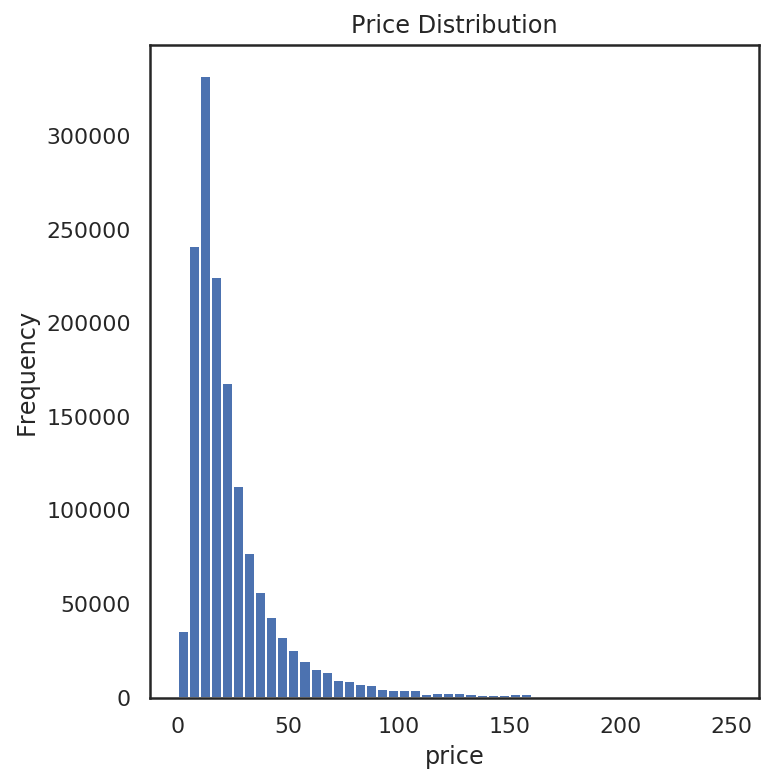

In [0]:
plt.subplot(1, 2, 1)
(data['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)



The price distribution is right skewed. Most of the values seems to be between 10-20 but there are some high prices in the dataset as well. **Transforming the price to a logarithmic scale** will probably help us achieve better results in this case. 

Text(0.5, 1.0, 'Price Distribution')

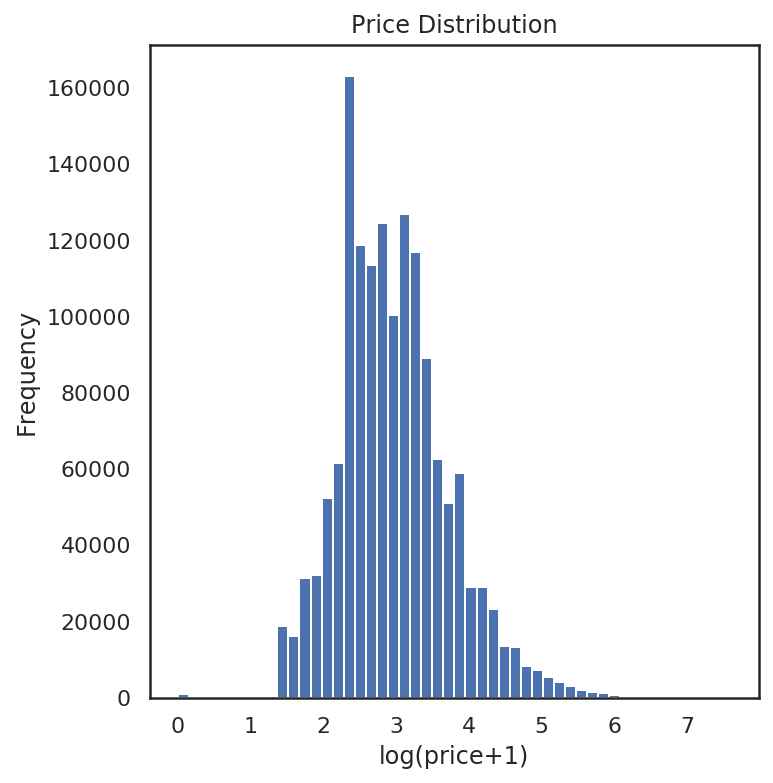

In [0]:
plt.subplot(1, 2, 2)
np.log(data['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)





# **Explore Missing Values**

below we can see a heat map that shows which attribute has the most missing values.

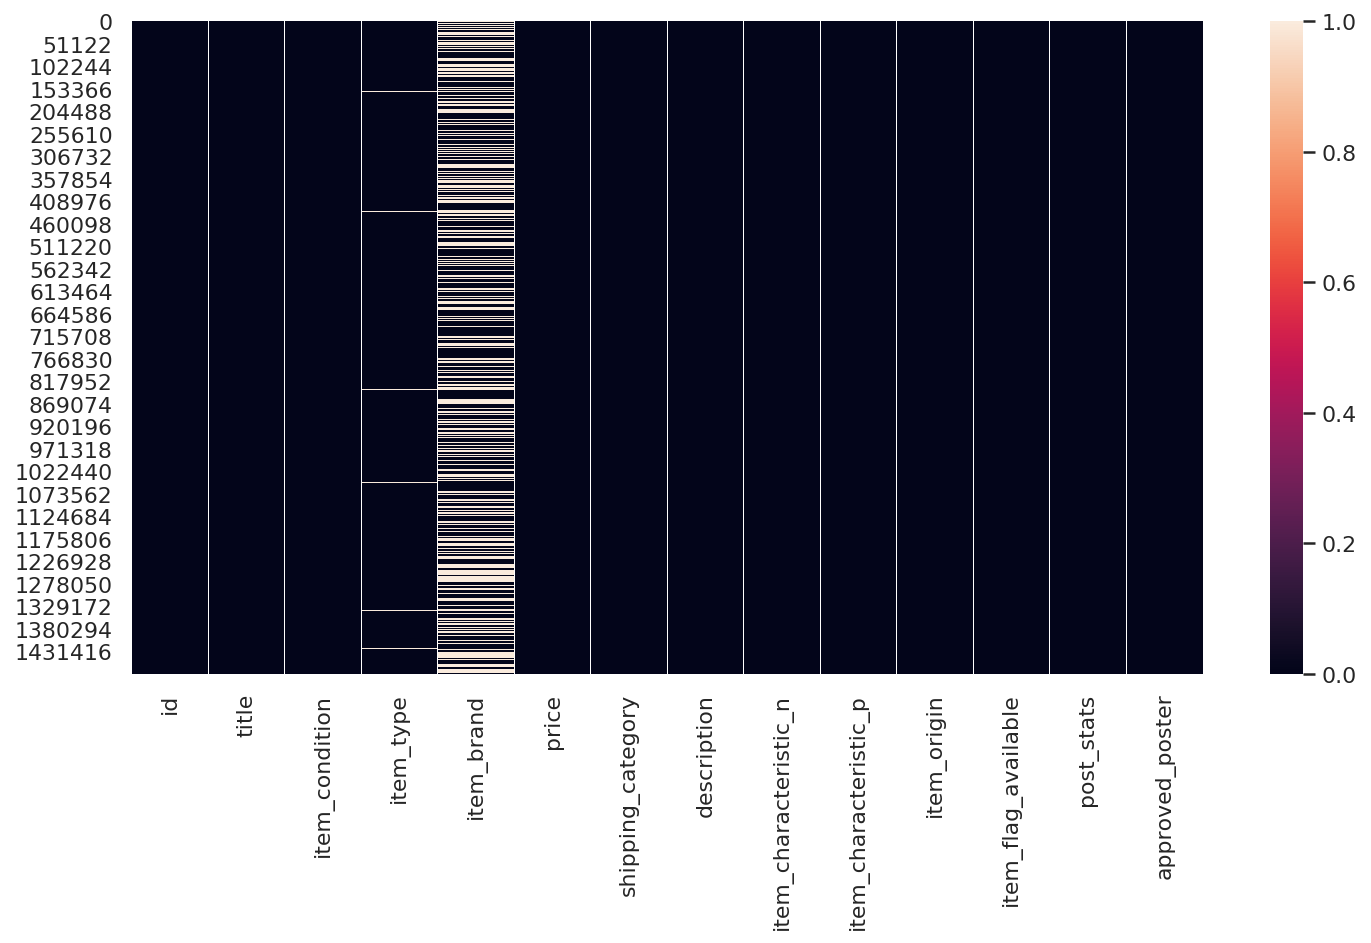

In [0]:

plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull())
plt.show()

In [0]:
print('Items with no brand name: %d' %data['item_brand'].isnull().sum())
print('Items with no type: %d' %data['item_type'].isnull().sum())
print('Items that do not have a description: %d' %data['description'].isnull().sum())

Items with no brand name: 632682
Items with no type: 6327
Items that do not have a description: 4


# **Exploratory Data Analysis**

Correlation matrix

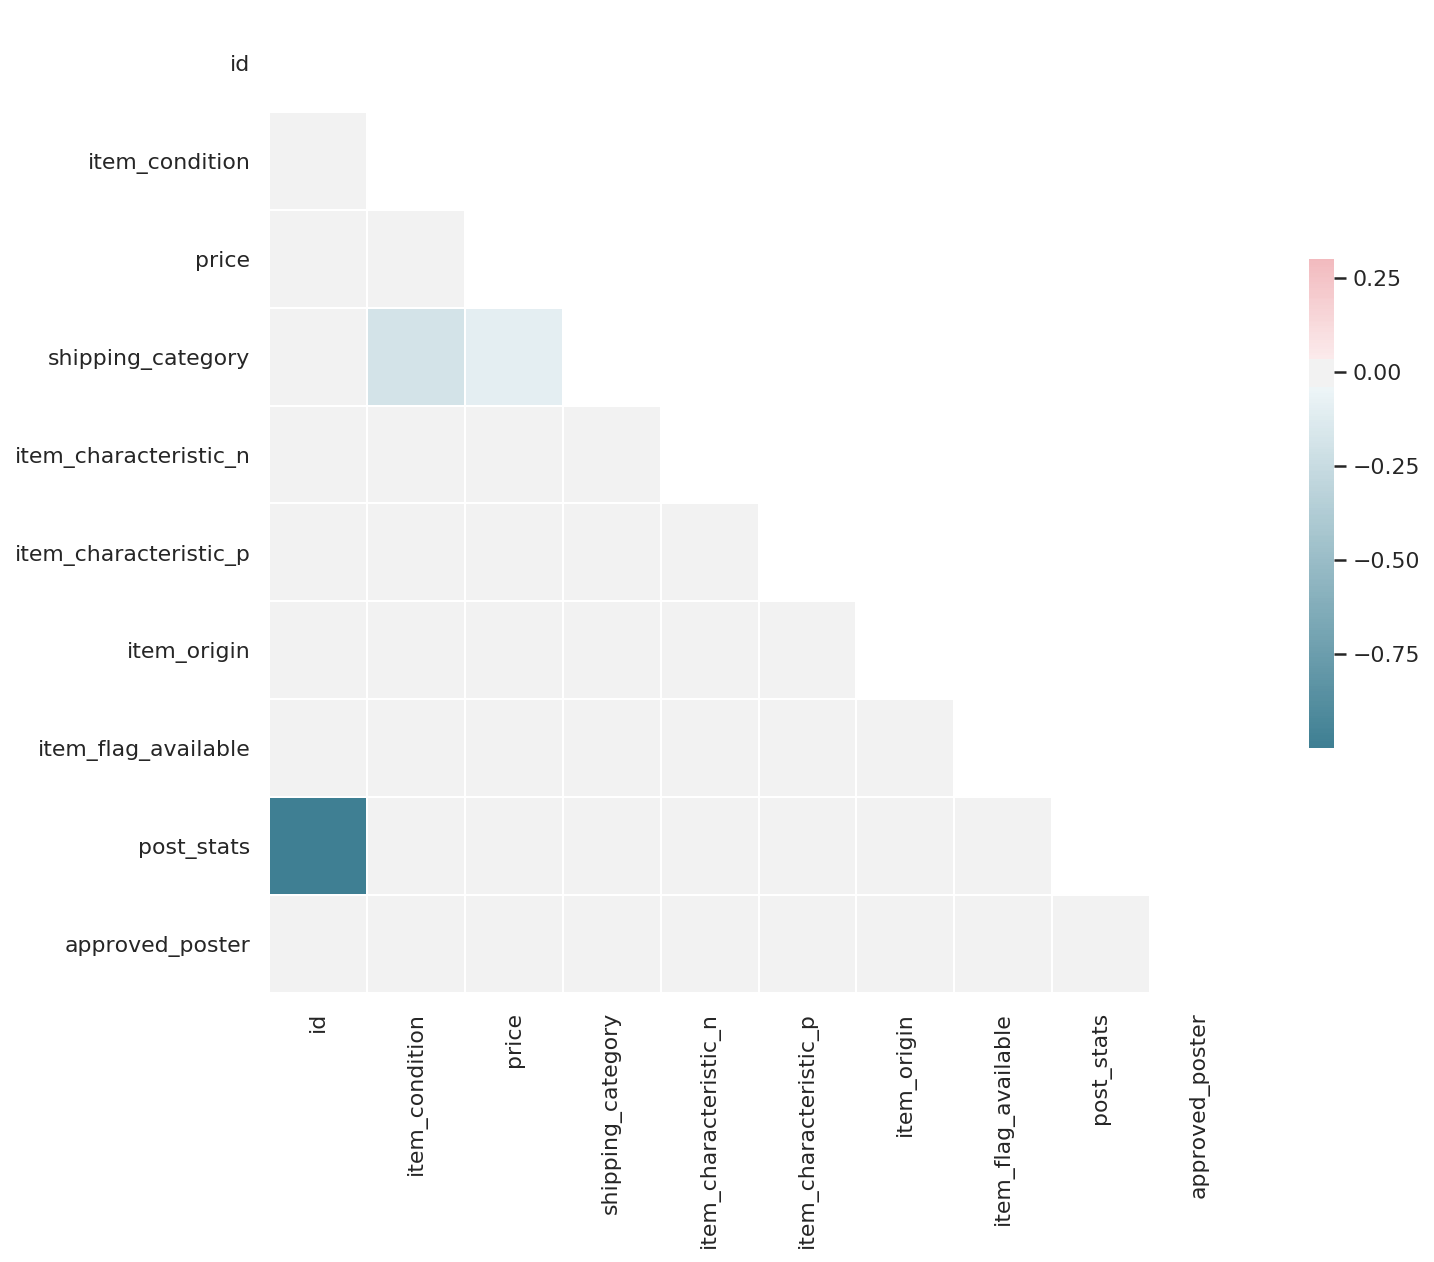

In [0]:

corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})





Let's do some general observations first. 

1.   Approved Poster: over 88% of the items does not have a verified poster. There seems to be no difference between the average price (on log scale) for approved or non-approved poster. 


False    0.888888
True     0.111112
Name: approved_poster, dtype: float64


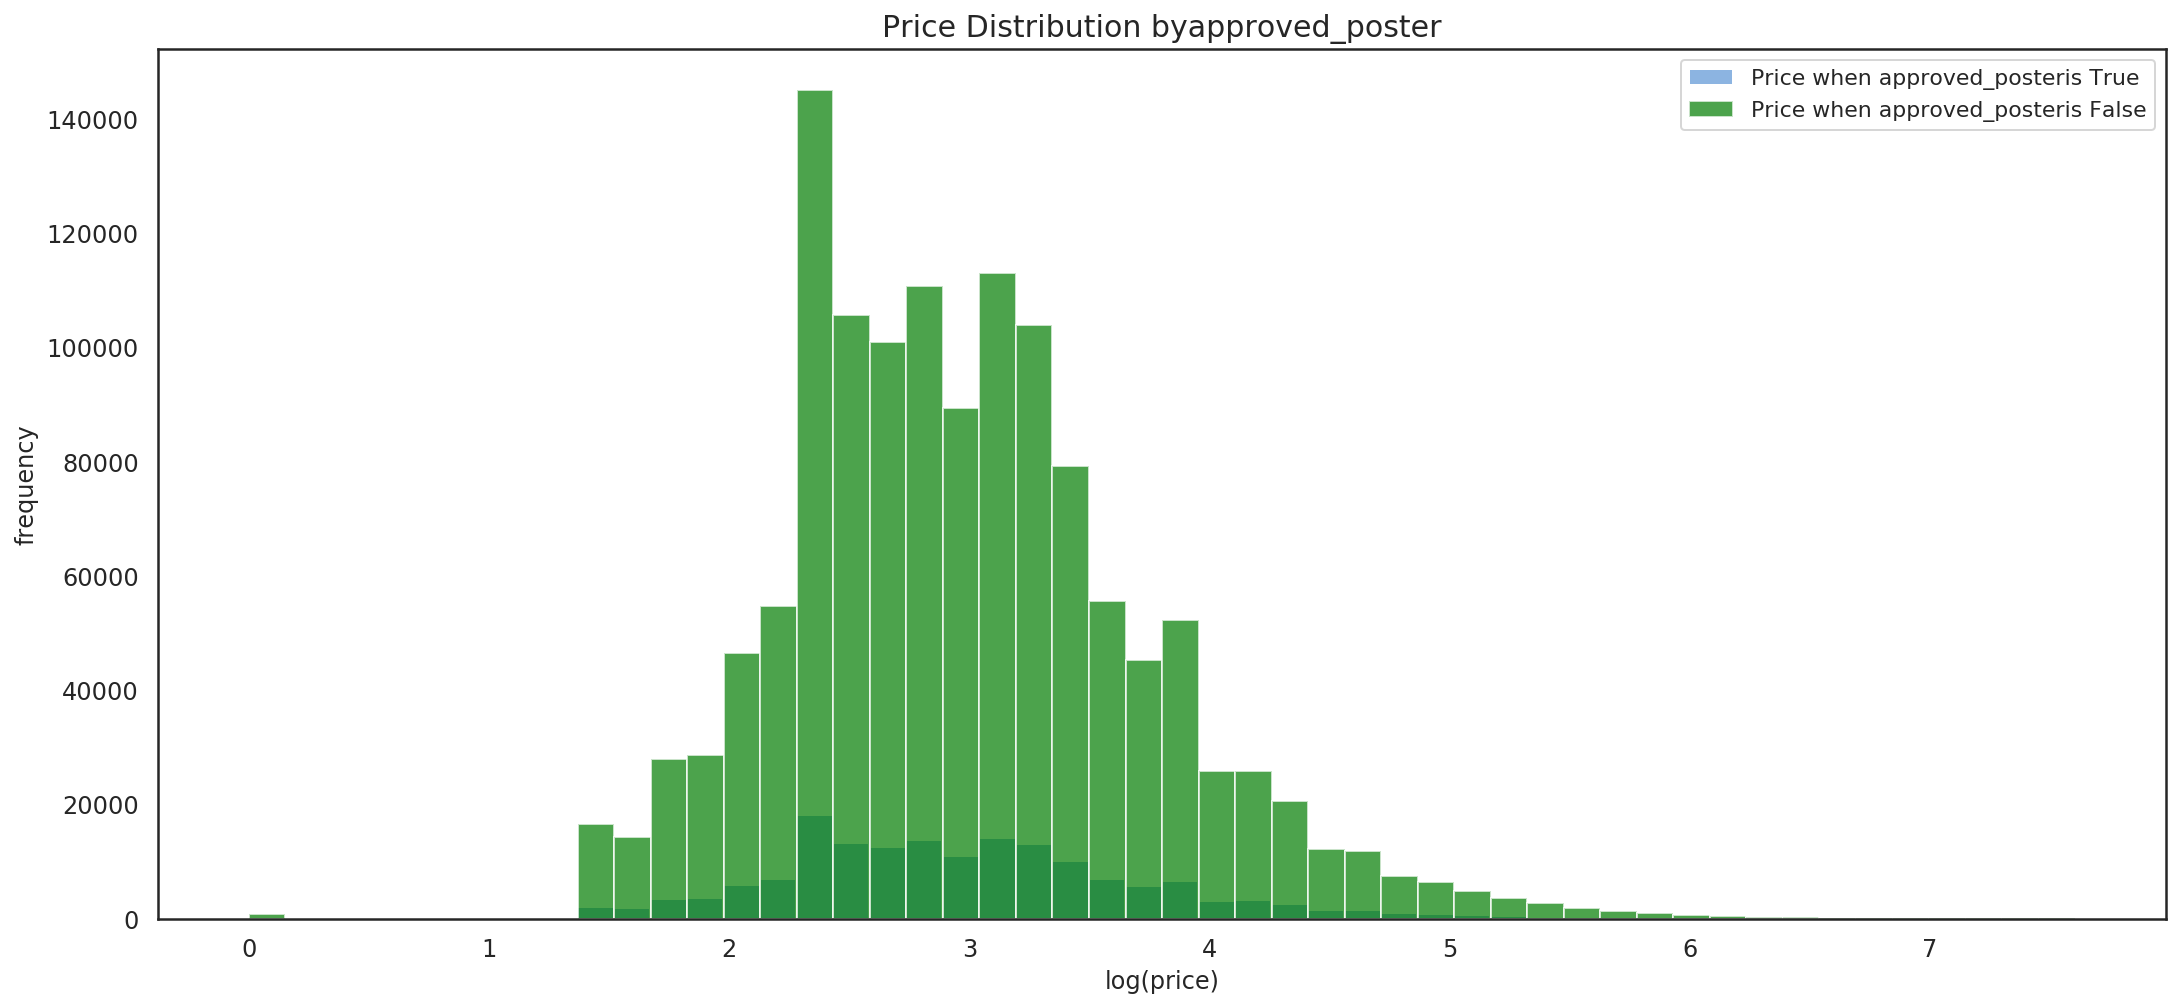

The average price is 2.98 if poster is not approved
The average price is 2.98 if poster is approved


In [0]:
print(data['approved_poster'].value_counts() / len(data))
false_items, true_items = price_distribution_by_binaryData(data, 'approved_poster')


2. Shipping Category: 

In 55% of the items buyer pays for the shipping. From the price distribution between if buyer pays for the shipping or not, Overal the price seems higher if buys pays for the shipping. 

0    0.552726
1    0.447274
Name: shipping_category, dtype: float64


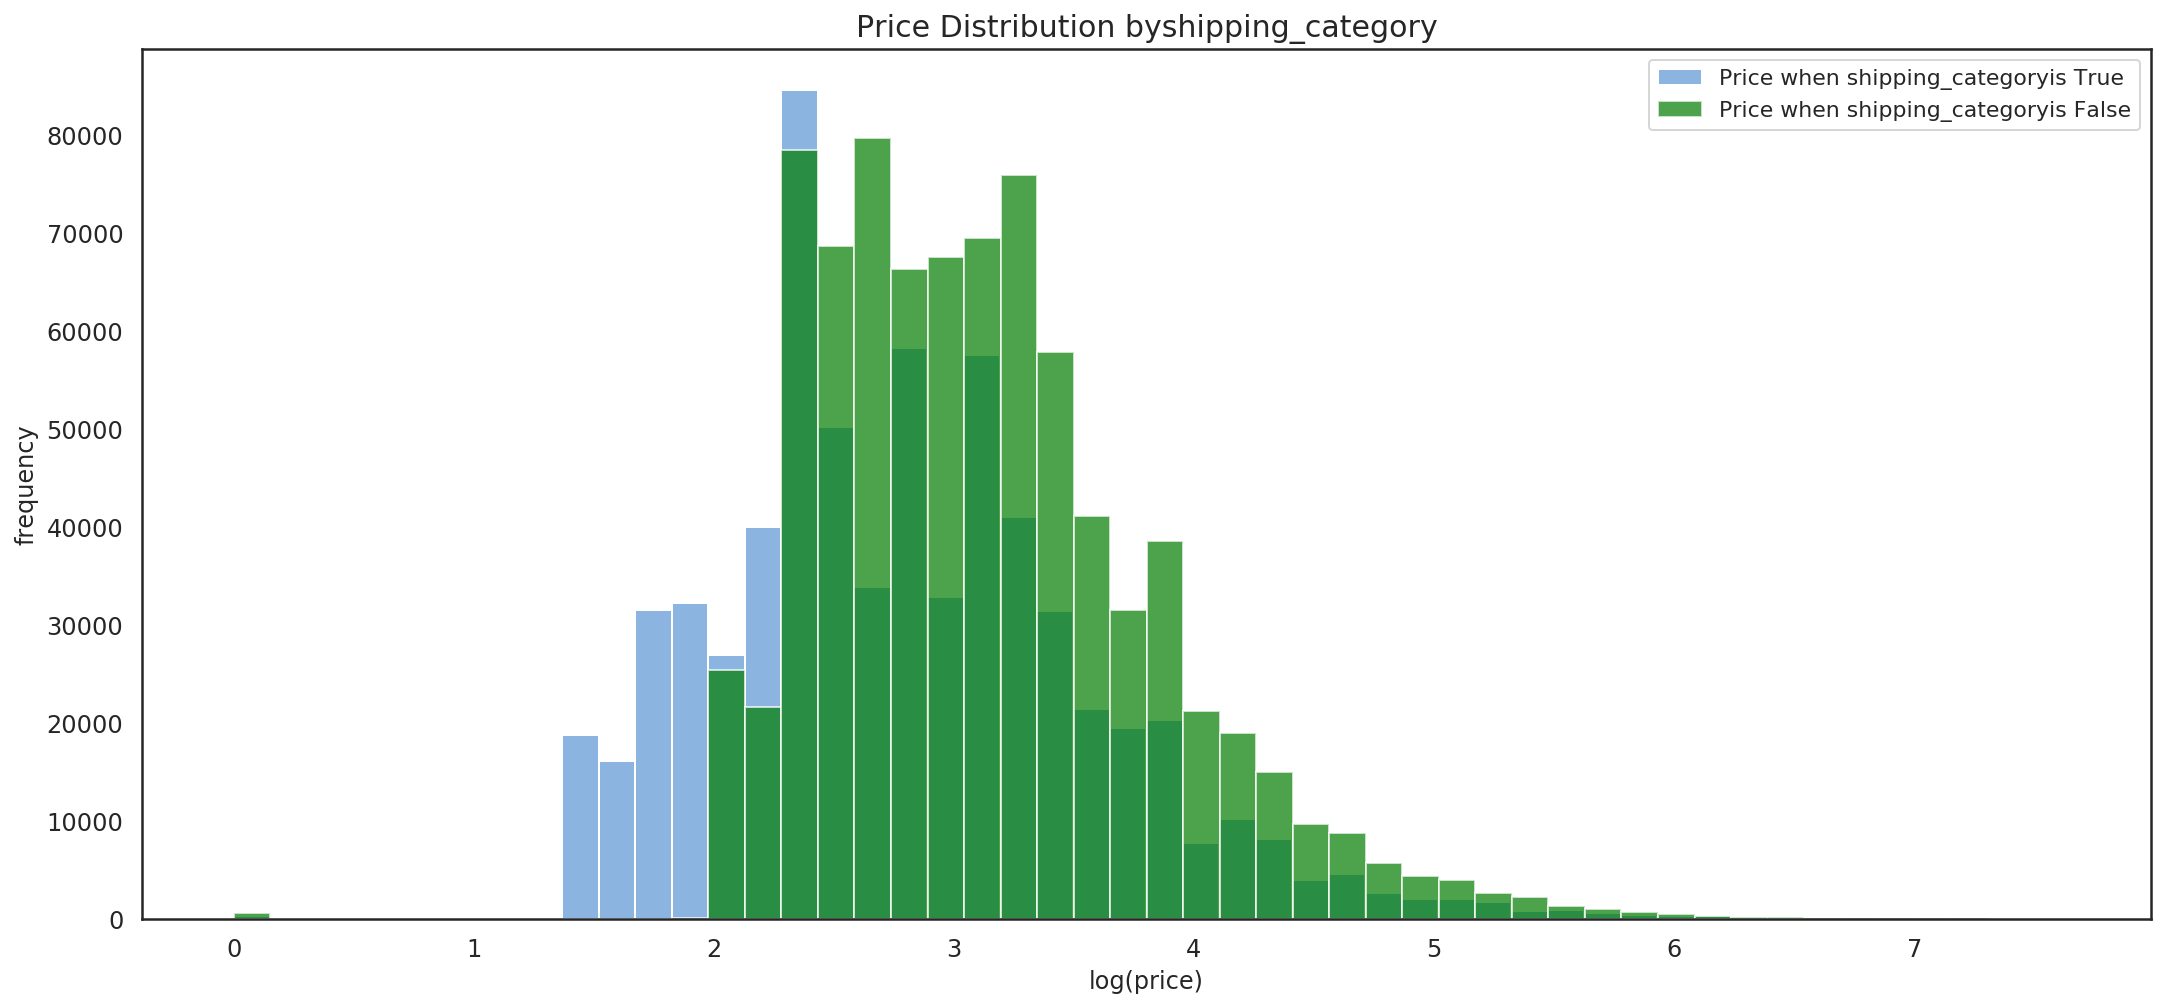

In [0]:
print(data['shipping_category'].value_counts() / len(data))
false_items, true_items = price_distribution_by_binaryData(data, 'shipping_category')


3. Item Condition:  Price seems to be various between different item condition.  

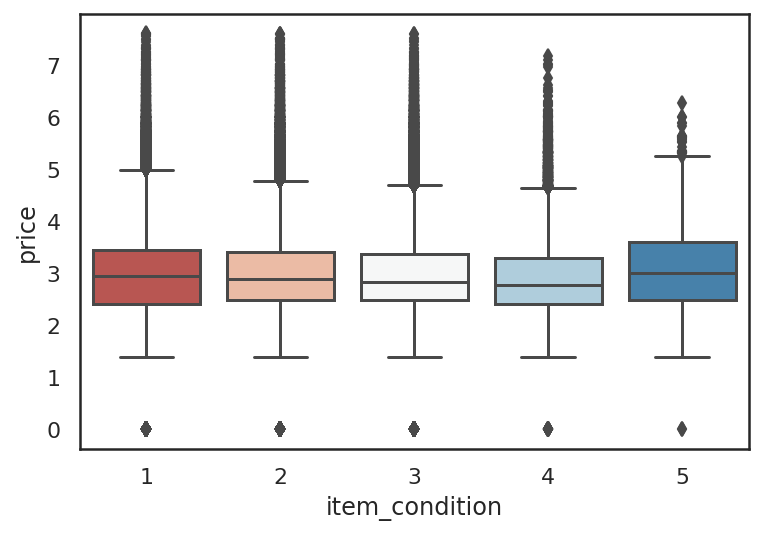

In [0]:
sns.boxplot(x = 'item_condition', y = data['price'], data = data, palette = sns.color_palette('RdBu',5))

Is there any correlation between non text features and the price?

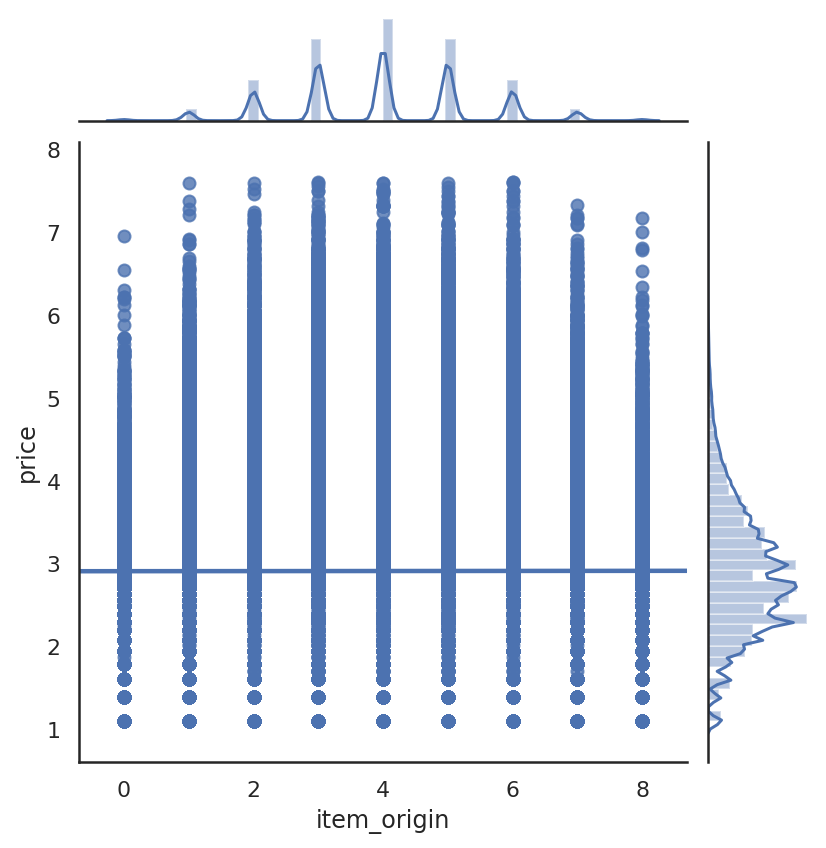

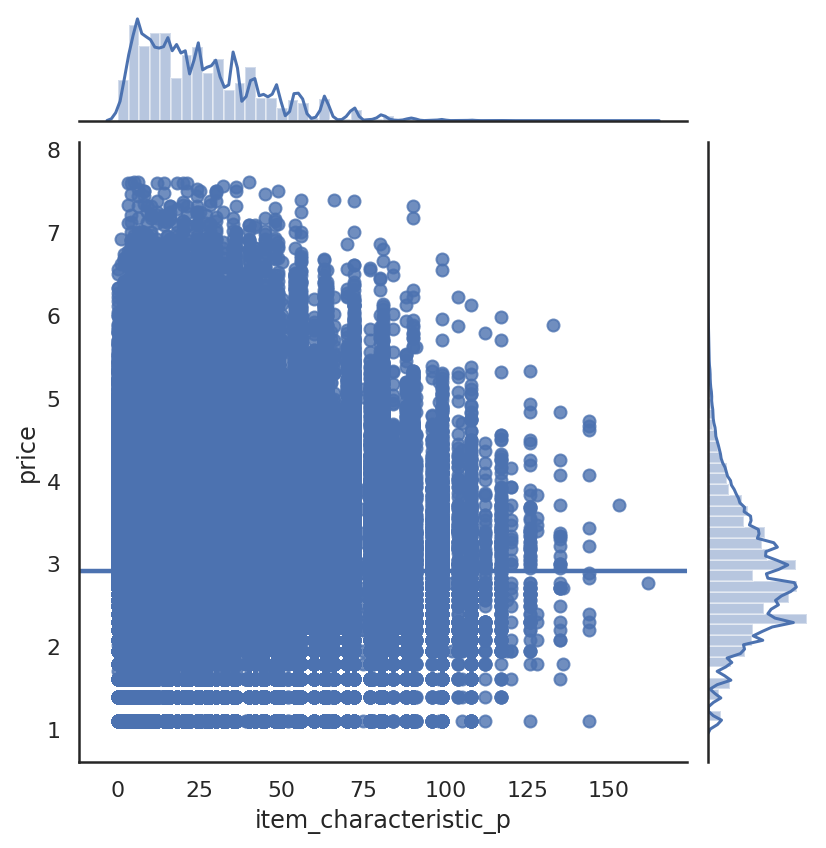

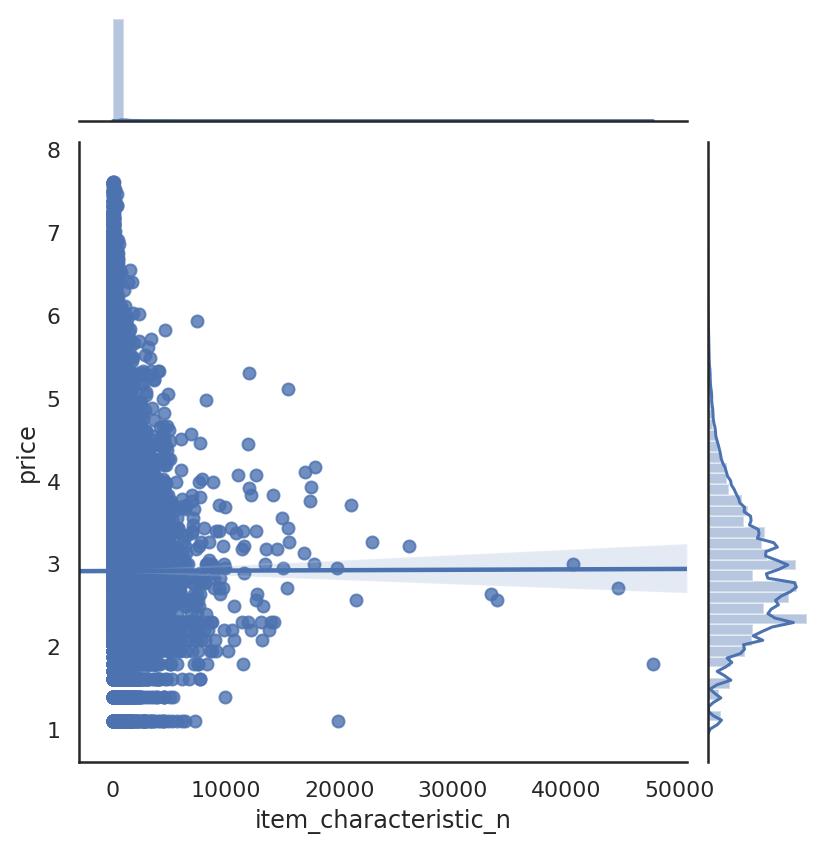

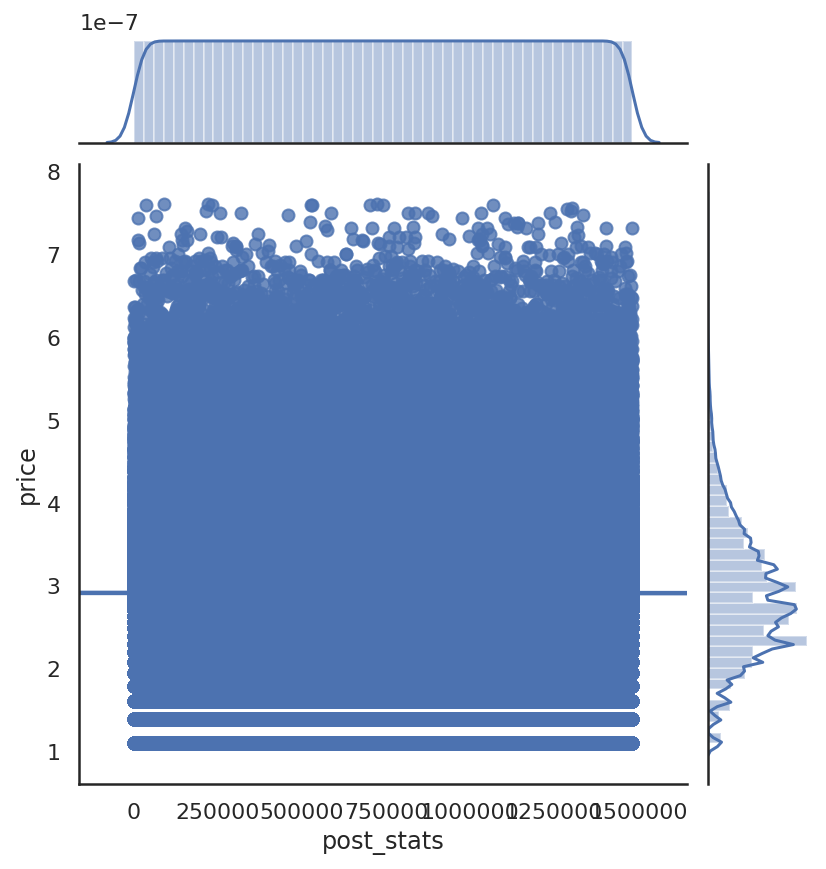

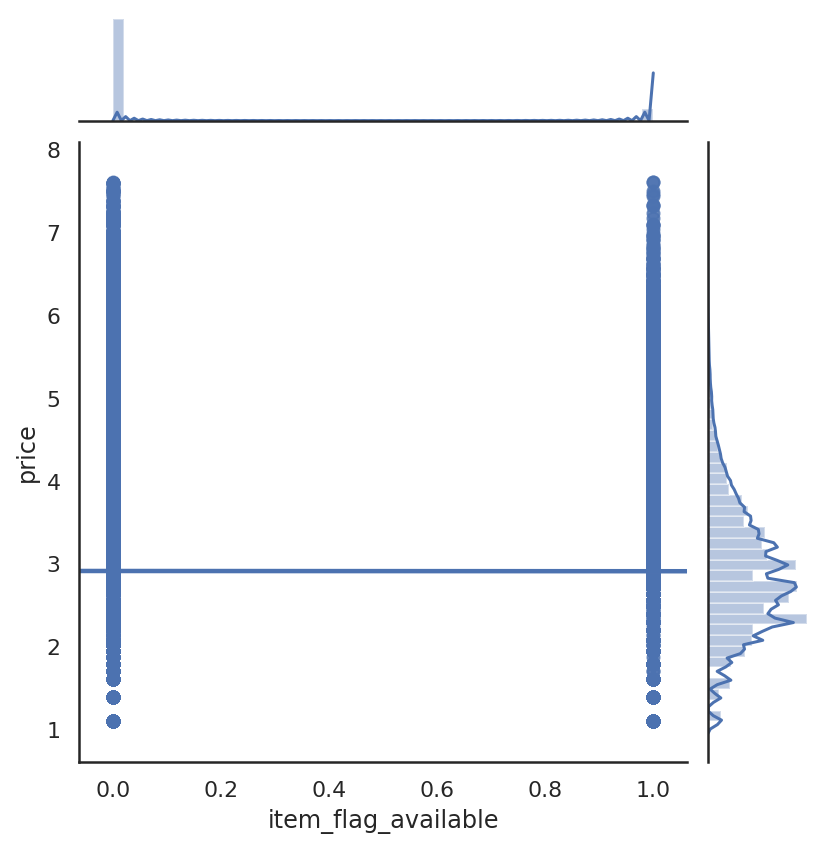

In [0]:
sns.jointplot(x=data['item_origin'], y=data['price'], kind='reg')
sns.jointplot(x=data['item_characteristic_p'], y=data['price'], kind='reg')
sns.jointplot(x=data['item_characteristic_n'], y=data['price'], kind='reg')
sns.jointplot(x=data['post_stats'], y=data['price'], kind='reg')
sns.jointplot(x=data['item_flag_available'], y=data['price'], kind='reg')

# **Data Cleanup**
item_characteristic_p: does not seem to be a relevant feature on the price prediciton.

The last step of data prepration is to drop the values when price is 0 and transform target variable to logarithmic scale.




In [0]:
handle_missing_inplace(data)
to_categorical(data)
cleaning(data)
data = data[data['price'] != 0].reset_index(drop=True)
data['price']= np.log(data['price'])


# **Build the model with traditional NLP**

In [0]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    max_features=50000, 
    ngram_range=(1, 3),
     stop_words='english',
    token_pattern=None)  

X_type = tfidf.fit_transform(data['item_type'])
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(data['item_brand'])

cv = CountVectorizer(min_df=10)
X_title = cv.fit_transform(data['title'])

tv = TfidfVectorizer(max_features=50000, 
                     ngram_range=(1, 3),
                     stop_words='english',
                     tokenizer=dummy_fun,
                     preprocessor=dummy_fun,)
X_description = tv.fit_transform(data['description'])

In [0]:
X_numeric = csr_matrix(pd.get_dummies(data[['item_condition', 
                                            'approved_poster',
                              'shipping_category', 
                              'item_origin',
                              'approved_poster',
                              'item_characteristic_p',
                              'item_flag_available'
                              ]], sparse = True).values)

In [0]:
X_all_text = hstack((X_numeric, X_description, X_brand, X_type, X_title)).tocsr()

we can remove description and title , since text data does not seem meaningful and see if this has any impact on the error. 

In [0]:
X = hstack((X_numeric, X_brand, X_type)).tocsr()

In [0]:
# reduce the feature columns by removing all features with a document frequency smaller than 1
mask = np.array(np.clip(X.getnnz(axis=0) - 1, 0, 1), dtype=bool)
X = X[:, mask]

mask = np.array(np.clip(X_all_text.getnnz(axis=0) - 1, 0, 1), dtype=bool)
X_all_text = X_all_text[:, mask]

In [0]:
def get_lgb_result(X):
  X_train, X_test, y_train, y_test = train_test_split(X, data['price'], random_state=42, train_size=0.1, test_size=0.02)

  params = {
          'learning_rate': 0.75,
          'application': 'regression',
          'max_depth': 3,
          'num_leaves': 100,
          'verbosity': -1,
          'metric': 'RMSE',
      }
  gbm = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=3200, verbose_eval=100)
  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  print('The rmse of prediction :', mean_squared_error(y_test, y_pred) ** 0.5)

# pickle.dump( gbm, open( "gbm.p", "wb" ) )

In [0]:
print("using only brand and type ")
get_lgb_result(X)

print("using all text features ")
get_lgb_result(X_all_text)

using only brand and type 
The rmse of prediction : 0.603767209076339
using all text features 
The rmse of prediction : 0.5526172927970087


Train with other models

In [0]:
def score_model(model, X_train, y_train):
    kf = KFold(3, shuffle=True, random_state=42).get_n_splits(X_train)
    model_score = np.mean(cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf, n_jobs=-1))
    return((type(model).__name__,model_score))

In [0]:
  model_scores = pd.DataFrame(columns=['model','NMSE'])
  reg_model = [Ridge(),Lasso(), GradientBoostingRegressor(),XGBRegressor()]
  for model in reg_model:
    sc = score_model(model, X, data['price'])
    model_scores = model_scores.append({'model':sc[0],'NMSE':sc[1]},ignore_index=True)    


In [0]:
model_scores.sort_values('NMSE',ascending=False)


,model,NMSE
0,Ridge,-0.368129
3,XGBRegressor,-0.438756
2,GradientBoostingRegressor,-0.443028
1,Lasso,-0.622433


In [0]:
pickle.dump( model_scores, open( "model_scores.p", "wb" ) )



Features are a mixture of text and numeric features. We build a model by converting text features to numerical value (tf-idf) and then merge it with the rest of numercial features OR we can build two separate model one for text features one for non-text and then combine the result of two models. 

# **Build the model using doc2Vec and google pre-trained model**




 What if instead of bag of words and tf-idf we use Average of Word2Vec vectors with TF-IDF

In [0]:
#load and cleanup the data
data = pd.read_csv("train_processed.csv") 
handle_missing_inplace(data)
cleaning(data)
data = data[data['price'] != 0].reset_index(drop=True)
data['price']= np.log(data['price'])

model = gensim.models.KeyedVectors.load_word2vec_format('googlenewsvectorsnegative300.bin', binary=True)


In [0]:

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.vocab]
    if doc ==[]:
      return np.zeros(300,)
    return np.mean(word2vec_model[doc], axis=0)

def transform(train, label):
  transformed = []
  for doc in train[label].values: 
    transformed.append(document_vector(model, doc))
  return transformed

X_type_v= np.array(transform(data, 'item_type'))


In [0]:
X_all = np.hstack((data[['item_condition', 
                         'approved_poster',
                              'shipping_category', 
                              'item_origin',
                              'item_characteristic_p',
                              'item_flag_available'
                              ]], X_type_v))

In [0]:
pickle.dump( X_all, open( "X_vec.p", "wb" ) )

In [10]:
get_lgb_result(X_all)


The rmse of prediction : 0.6783490931301932
